In [ ]:
# finetune_sam_mouse_1024_full.py
import os
import random
from pathlib import Path
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
import torch.nn.functional as F
from torch import nn, optim
from tqdm import tqdm
import torchvision.transforms.functional as TF
import numpy as np

# ---------- SAM import ----------
try:
    from segment_anything import sam_model_registry
except ImportError:
    raise ImportError("Please install/clone segment-anything: https://github.com/facebookresearch/segment-anything")

# ---------- CONFIG ----------
DATA_FILE = r'C:\Users\B467130\Documents\segment\dataset_20251005.pt'
IM_SIZE = 1024
BATCH_SIZE = 4
LR = 1e-4
EPOCHS = 30
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAM_MODEL_VERSION = 'vit_b'
SAM_CHECKPOINT_DIR = Path('./sam_checkpoints')
SAM_CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
NUM_CLASSES = 2
SAVE_DIR = Path("./outputs")
SAVE_DIR.mkdir(exist_ok=True, parents=True)

# ---------- Download SAM ----------
import requests
CHECKPOINT_URLS = {
    'vit_b': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth',
    'vit_l': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_4b8939.pth',
    'vit_h': 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth',
}

def download_checkpoint(version: str, save_dir: Path):
    checkpoint_path = save_dir / f"sam_{version}.pth"
    if checkpoint_path.exists():
        print(f"Checkpoint for {version} already exists at {checkpoint_path}")
        return checkpoint_path
    url = CHECKPOINT_URLS[version]
    print(f"Downloading SAM {version} checkpoint...")
    response = requests.get(url)
    response.raise_for_status()
    with open(checkpoint_path, 'wb') as f:
        f.write(response.content)
    print(f"Checkpoint saved to {checkpoint_path}")
    return checkpoint_path

def load_sam(version: str, checkpoint_dir: Path):
    checkpoint_path = download_checkpoint(version, checkpoint_dir)
    sam = sam_model_registry[version](checkpoint=str(checkpoint_path))
    sam.to(DEVICE)
    # Freeze image encoder and prompt encoder
    for p in sam.image_encoder.parameters():
        p.requires_grad = False
    if hasattr(sam, "prompt_encoder"):
        for p in sam.prompt_encoder.parameters():
            p.requires_grad = False
    return sam

# ---------- Data Augmentations ----------
def random_cutout(image, label, max_h=50, max_w=50):
    _, h, w = image.shape
    cutout_height = random.randint(10, max_h)
    cutout_width = random.randint(10, max_w)
    top = random.randint(0, h - cutout_height)
    left = random.randint(0, w - cutout_width)
    image[:, top : top + cutout_height, left : left + cutout_width] = 0
    label[:, top : top + cutout_height, left : left + cutout_width] = 0
    return image, label

def adjust_brightness(image, label, brightness_factor=0.2):
    image = TF.adjust_brightness(image, 1 + (random.random() * 2 - 1) * brightness_factor)
    return image, label

def random_jitter(image, max_jitter=0.1):
    noise = torch.randn_like(image) * max_jitter
    image = torch.clamp(image + noise, 0, 1)
    return image

def motion_blur(image, kernel_size=5, angle=45):
    C, H, W = image.shape
    kernel = torch.zeros((kernel_size, kernel_size))
    center = kernel_size // 2
    for i in range(kernel_size):
        kernel[center, i] = 1
    kernel = kernel / kernel.sum()
    kernel = kernel.unsqueeze(0).unsqueeze(0).repeat(C, 1, 1, 1)
    blurred_image = F.conv2d(image.unsqueeze(0), kernel, padding=kernel_size // 2, groups=C)
    return blurred_image.squeeze(0)

# ---------- Dataset ----------
class facemapdataset(Dataset):
    def __init__(self, data_file=DATA_FILE, transform=None):
        super().__init__()
        self.transform = transform
        self.data, self.targets = torch.load(data_file)

    def __len__(self):
        return len(self.data) * 10

    def __getitem__(self, index):
        base_index = index % len(self.data)
        aug_type = index // len(self.data)
        image, label = self.data[base_index].clone(), self.targets[base_index].clone()

        # Convert grayscale -> 3-channel for SAM
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        # Resize to 1024x1024
        image = TF.resize(image, [IM_SIZE, IM_SIZE])
        label = TF.resize(label, [IM_SIZE, IM_SIZE])

        # Apply augmentations
        if self.transform is not None:
            if aug_type == 1:
                image = image.flip([2])
                label = label.flip([2])
            elif aug_type == 2:
                angle = random.uniform(-15, 15)
                image = TF.rotate(image, angle)
                label = TF.rotate(label, angle)
            elif aug_type == 3:
                scale_factor = random.uniform(0.8, 1.5)
                image = self.zoom(image, scale_factor)
                label = self.zoom(label, scale_factor)
            if random.random() < 0.2:
                image, label = random_cutout(image, label)
            if random.random() < 0.2:
                image, label = adjust_brightness(image, label, 0.5)
            if random.random() < 0.2:
                image = motion_blur(image)
            if random.random() < 0.2:
                image = random_jitter(image)

        return image, label.long()

    def zoom(self, img, scale_factor):
        _, h, w = img.shape
        new_h, new_w = int(h * scale_factor), int(w * scale_factor)
        img = TF.resize(img, [new_h, new_w])
        img = TF.center_crop(img, [IM_SIZE, IM_SIZE])
        return img

# ---------- DataLoaders ----------
dataset = facemapdataset(transform="flip")
N = len(dataset)
train_idx = np.arange(int(0.6 * N))
val_idx = np.arange(int(0.6 * N), int(0.8 * N))
test_idx = np.arange(int(0.8 * N), N)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

loader_train = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
loader_val = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_sampler, drop_last=False)
loader_test = DataLoader(dataset, batch_size=1, sampler=test_sampler, drop_last=False)

# ---------- Training ----------
def train():
    sam = load_sam(SAM_MODEL_VERSION, SAM_CHECKPOINT_DIR)
    sam.train()

    emb_channels = {'vit_b':256,'vit_l':384,'vit_h':512}[SAM_MODEL_VERSION]
    sam._finetune_head = nn.Sequential(
        nn.Conv2d(emb_channels, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, NUM_CLASSES, kernel_size=1)
    ).to(DEVICE)

    optimizer = optim.AdamW(sam._finetune_head.parameters(), lr=LR, weight_decay=1e-6)

    for epoch in range(1, EPOCHS+1):
        pbar = tqdm(loader_train, desc=f"Epoch {epoch}/{EPOCHS}")
        for images, masks in pbar:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE).long()
            masks = masks.squeeze(1)

            with torch.no_grad():
                emb = sam.image_encoder(images)
                if isinstance(emb, tuple):
                    emb = emb[-1]

            logits = sam._finetune_head(emb)
            logits = F.interpolate(logits, size=(IM_SIZE, IM_SIZE), mode='bilinear', align_corners=False)
            loss = F.cross_entropy(logits, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item())

        # Validation
        sam.eval()
        iou_sum = 0
        with torch.no_grad():
            for images, masks in loader_val:
                images = images.to(DEVICE)
                masks_np = masks.squeeze(1).numpy()[0]
                emb = sam.image_encoder(images)
                if isinstance(emb, tuple):
                    emb = emb[-1]
                logits = sam._finetune_head(emb)
                logits = F.interpolate(logits, size=(IM_SIZE, IM_SIZE), mode='bilinear', align_corners=False)
                pred = torch.argmax(logits, dim=1).cpu().numpy()[0]
                intersection = np.logical_and(pred == 1, masks_np == 1).sum()
                union = np.logical_or(pred == 1, masks_np == 1).sum()
                iou_sum += intersection / (union + 1e-6)
            print(f"[VAL] Epoch {epoch} mean IoU: {iou_sum / len(loader_val)}")
        sam.train()

        torch.save({
            "epoch": epoch,
            "model_state": sam.state_dict(),
            "optimizer_state": optimizer.state_dict()
        }, SAVE_DIR / f"sam_mouse_epoch{epoch}.pth")

#if __name__ == "__main__":
#    train()




In [8]:
import torch
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
from PIL import Image
import numpy as np
from pathlib import Path
import random
from segment_anything import sam_model_registry

# ---------- CONFIG ----------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_FILE = r"C:\Users\avs20\Documents\GitHub\DeepEnsampleGUI\napari-threshold\Unet_training_20250909\dataset_20251005.pt"
IM_SIZE = 1024
NUM_TEST_IMAGES = 5
MODEL_PATH = Path("./outputs/sam_mouse_epoch11.pth")
OUTPUT_DIR = Path("./outputs/masked_test_images")
OUTPUT_DIR.mkdir(exist_ok=True)

# ---------- SAM Checkpoints ----------
SAM_CHECKPOINT_DIR = Path("./sam_checkpoints")
SAM_CHECKPOINT_DIR.mkdir(exist_ok=True)
VIT_B_CHECKPOINT = SAM_CHECKPOINT_DIR / "sam_vit_b_01ec64.pth"
VIT_B_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"

if not VIT_B_CHECKPOINT.exists():
    import urllib.request
    print("Downloading SAM ViT-B checkpoint...")
    urllib.request.urlretrieve(VIT_B_URL, VIT_B_CHECKPOINT)
    print(f"Downloaded to {VIT_B_CHECKPOINT}")

# ---------- Dataset ----------
class facemapdataset(Dataset):
    def __init__(self, data_file=DATA_FILE, transform=None):
        super().__init__()
        self.transform = transform
        self.data, self.targets = torch.load(data_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index].clone(), self.targets[index].clone()
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
        image = TF.resize(image, [IM_SIZE, IM_SIZE])
        label = TF.resize(label, [IM_SIZE, IM_SIZE])
        return image, label.long()

# ---------- Load Dataset ----------
dataset = facemapdataset(transform=None)
N = len(dataset)
test_idx = list(range(int(0.8 * N), N))
random.seed(42)
test_idx = random.sample(test_idx, NUM_TEST_IMAGES)

test_sampler = SubsetRandomSampler(test_idx)
loader_test = DataLoader(dataset, batch_size=1, sampler=test_sampler, drop_last=False)

# ---------- Load SAM ----------
sam = sam_model_registry["vit_b"](checkpoint=VIT_B_CHECKPOINT).to(DEVICE)
sam.eval()

# ---------- Define finetune head (must match training) ----------
emb_channels = 256  # for vit_b
finetune_head = torch.nn.Sequential(
    torch.nn.Conv2d(emb_channels, 128, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(128, 2, kernel_size=1)
).to(DEVICE)

# Load your trained weights
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
sam.load_state_dict(checkpoint["model_state"], strict=False)
finetune_head.load_state_dict(checkpoint["optimizer_state"], strict=False)
finetune_head.eval()

# ---------- Inference ----------
with torch.no_grad():
    for i, (image, _) in enumerate(loader_test):
        image = image.to(DEVICE)
        orig_image = image.clone()

        # Encode image with SAM
        emb = sam.image_encoder(image)
        if isinstance(emb, tuple):
            emb = emb[-1]

        # Apply finetuned head
        logits = finetune_head(emb)
        logits = torch.nn.functional.interpolate(logits, size=(IM_SIZE, IM_SIZE),
                                                 mode='bilinear', align_corners=False)
        mask = torch.argmax(logits, dim=1).squeeze(0).cpu()  # [H, W]

        # Apply mask to original image
        image_np = orig_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        masked_image = image_np * mask[..., None].numpy()
        masked_image_uint8 = (masked_image * 255).astype(np.uint8)
        masked_image_pil = Image.fromarray(masked_image_uint8)

        # Save
        save_path = OUTPUT_DIR / f"test_masked_{i}.png"
        masked_image_pil.save(save_path)
        print(f"Saved masked image: {save_path}")



Saved masked image: outputs\masked_test_images\test_masked_0.png
Saved masked image: outputs\masked_test_images\test_masked_1.png
Saved masked image: outputs\masked_test_images\test_masked_2.png
Saved masked image: outputs\masked_test_images\test_masked_3.png
Saved masked image: outputs\masked_test_images\test_masked_4.png


In [1]:
pip install segmentation_models_pytorch

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.5 MB 1.2 MB/s eta 0:00:02
   ------------ --------------------------- 0.8/2.5 MB 1.1 MB/s eta 0:00:02
   ---------------- ----------------------- 1.0/2.5 MB 1.1 MB/s eta 0:00:02
   -------------------- ------------------- 1.3/2.5 MB 1.1 MB/s eta 0:00:02
   ------------------------- -------------- 1.6/2.5 MB 1.1 MB/s eta 0:00:01
   ----------------------------- ---------- 1.8/2.5 MB 1.1 MB/s eta 0:00:01
   --------------------------------- ------ 2.1/2.5 MB 1.1 MB/s eta 0:00:01
   --------------------------------- ------ 2.1/2.5 MB 1.1 MB/s eta 0:00:01
   ------------------------------------- -- 2.4/2.5 MB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 1.0 MB/s  0:00:02

   --------------------------------

In [ ]:
from torchvision import models
import segmentation_models_pytorch as smp  # pip install segmentation-models-pytorch

model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=1)


In [6]:
checkpoint_path = SAM_CHECKPOINT_DIR / f"sam_{SAM_MODEL_VERSION}.pth"
sam = sam_model_registry[SAM_MODEL_VERSION](checkpoint=str(checkpoint_path))
sam.to(DEVICE)
sam.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [8]:
data, targets = torch.load(DATA_FILE)

In [38]:
targets[0]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]]])

In [10]:
image = data[0]

image = TF.resize(image, [IM_SIZE, IM_SIZE])
if image.shape[0] == 1:
    image = image.repeat(3, 1, 1)
image = image.to(DEVICE)

In [11]:
with torch.no_grad():
    image_embedding = sam.image_encoder(image.unsqueeze(0))
    if isinstance(image_embedding, tuple):
        image_embedding = image_embedding[-1]

In [13]:
from segment_anything.utils.transforms import ResizeLongestSide
transform = ResizeLongestSide(IM_SIZE)
input_point = torch.tensor([[512, 512]])  # center point
input_label = torch.tensor([1])  # foreground
point_coords = transform.apply_coords(input_point.numpy(), image.shape[1:])



In [39]:
from segment_anything import SamPredictor
sam = sam_model_registry[SAM_MODEL_VERSION](checkpoint=str(checkpoint_path))
sam.to(DEVICE)
predictor = SamPredictor(sam)
import numpy as np
image_np = image.permute(1, 2, 0).cpu().numpy()  # from CHW to HWC
targets_np = targets[0].permute(1, 2, 0).cpu().numpy()  # from CHW to HWC
predictor.set_image(image_np)
input_point = np.array([[512, 512]])  # center point
input_label = np.array([1])           # foreground
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)


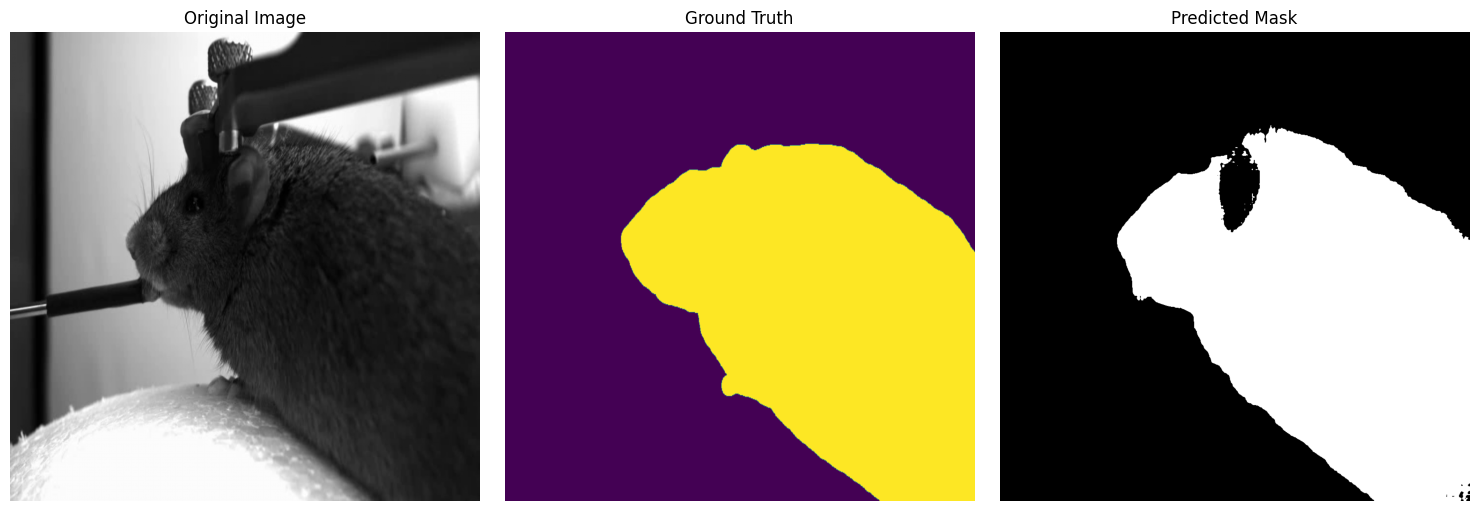

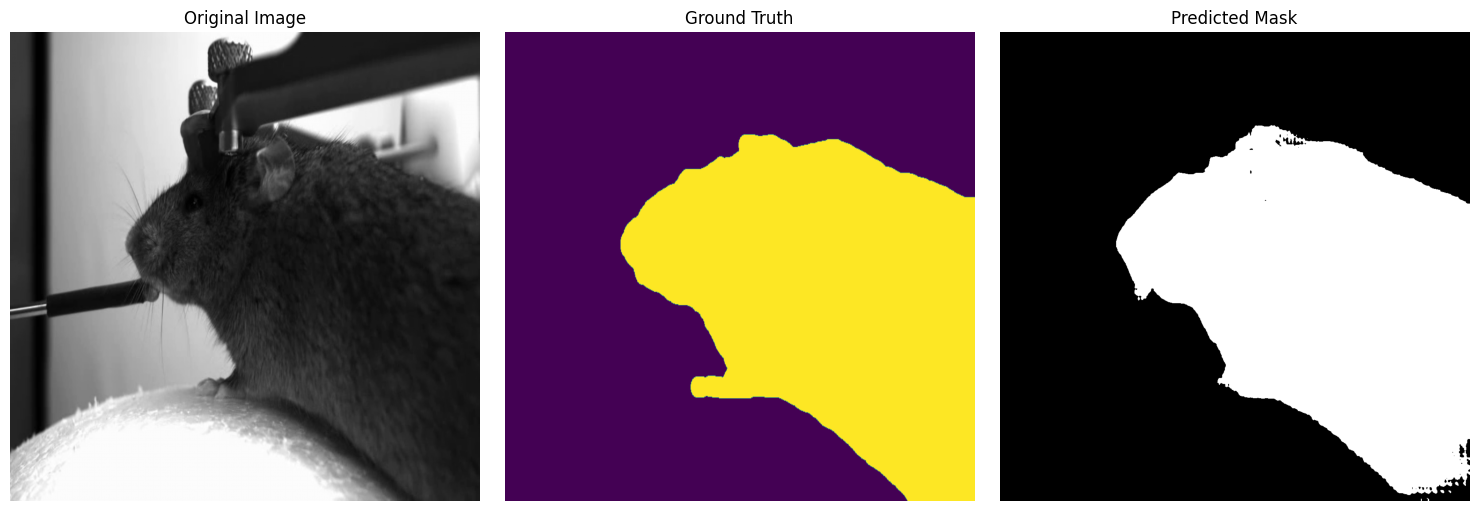

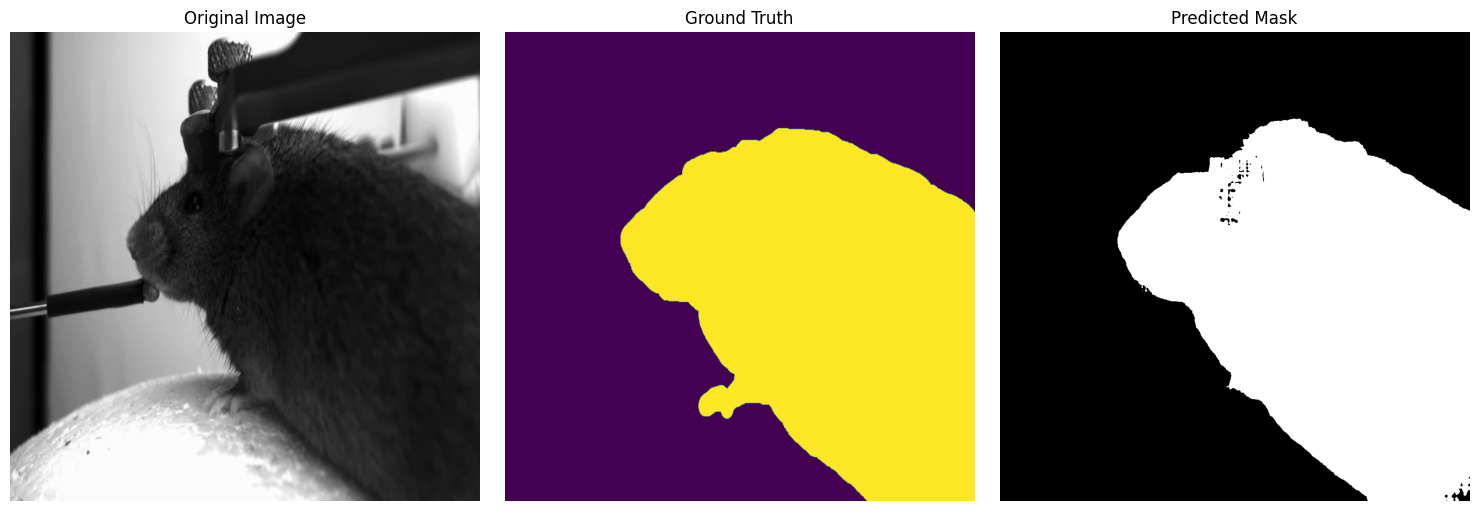

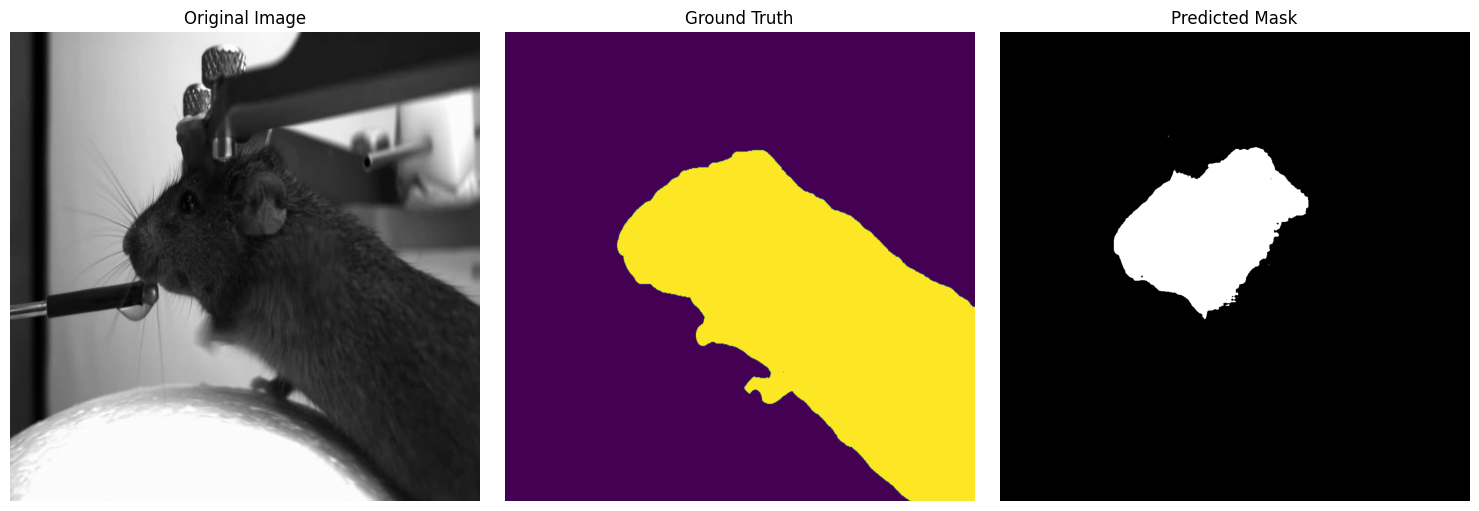

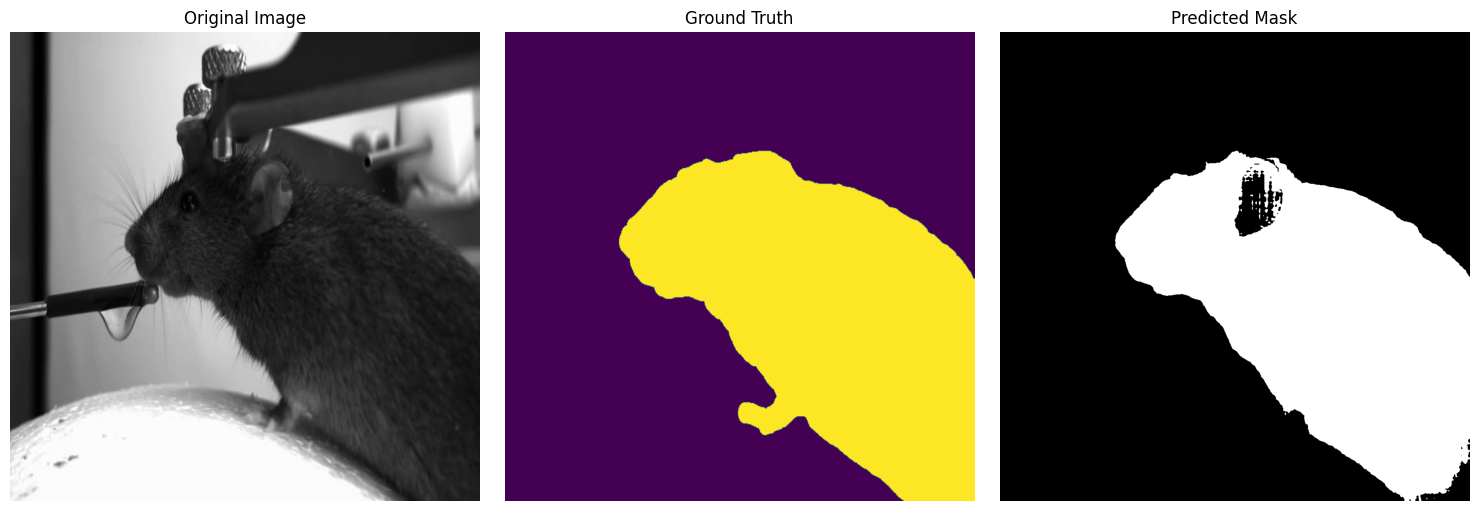

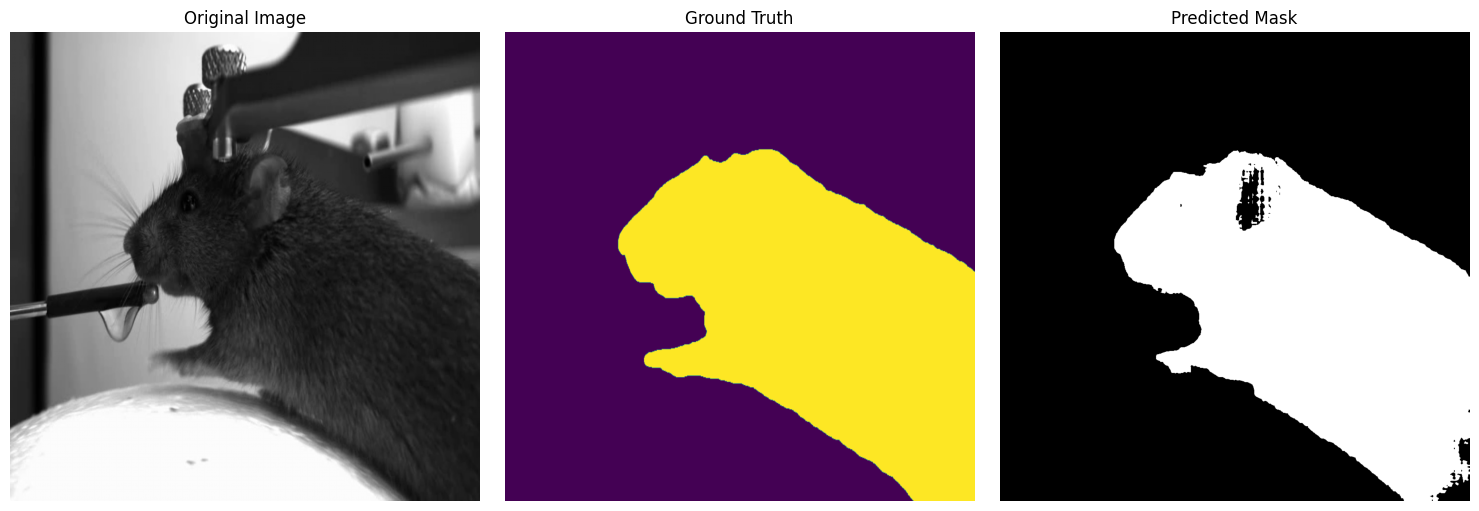

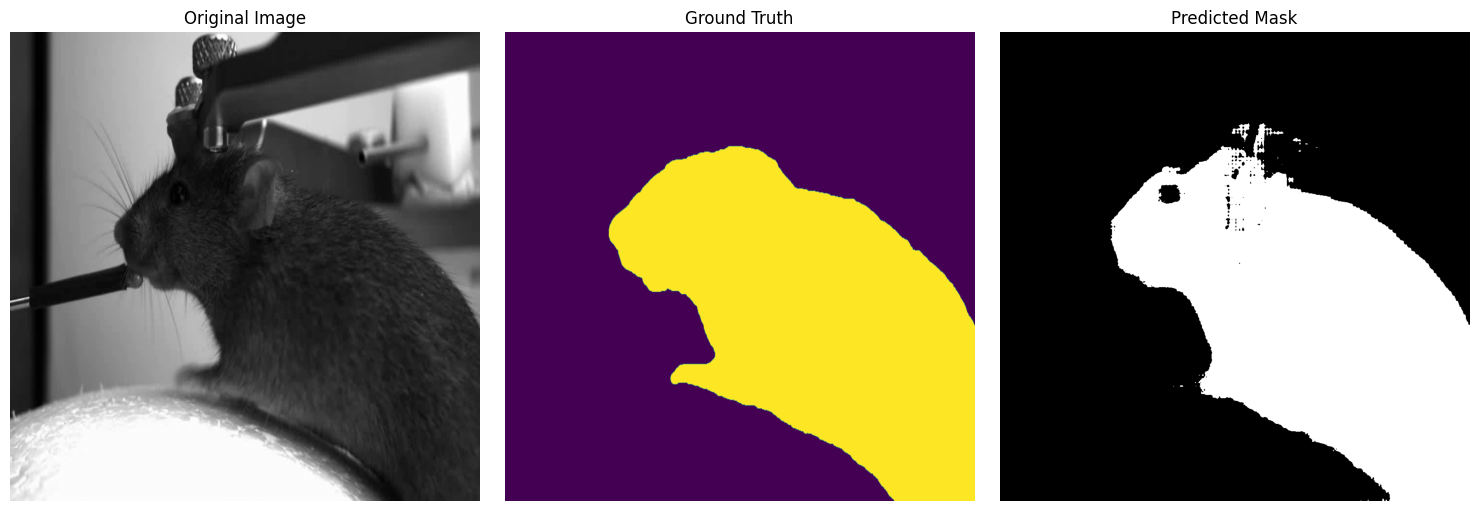

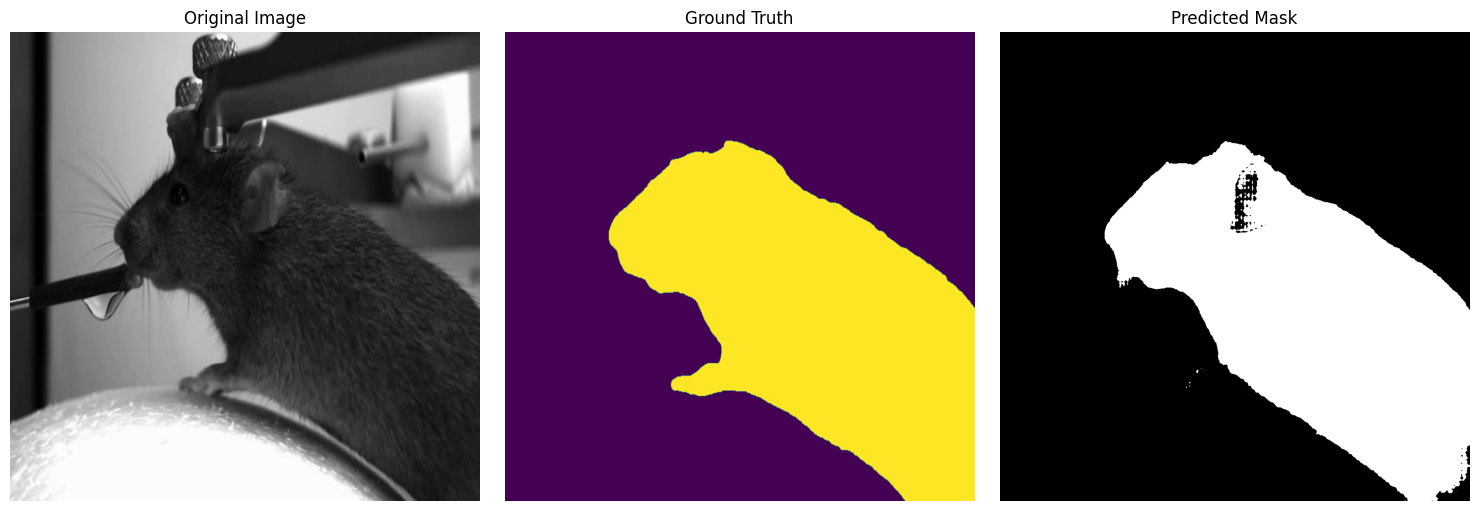

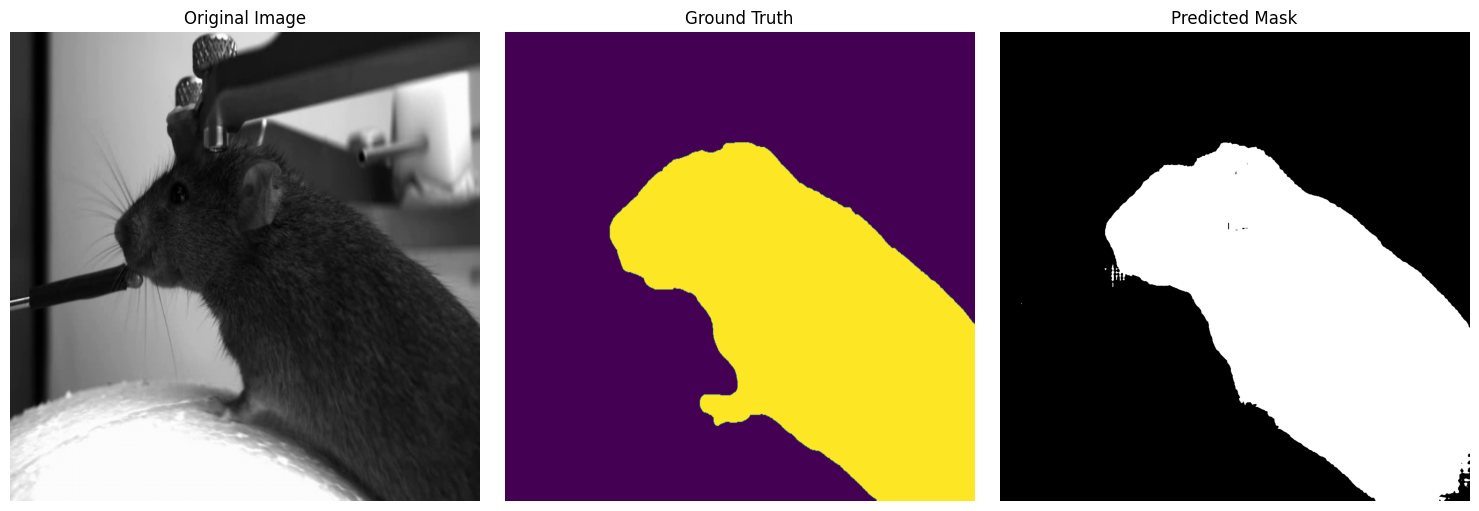

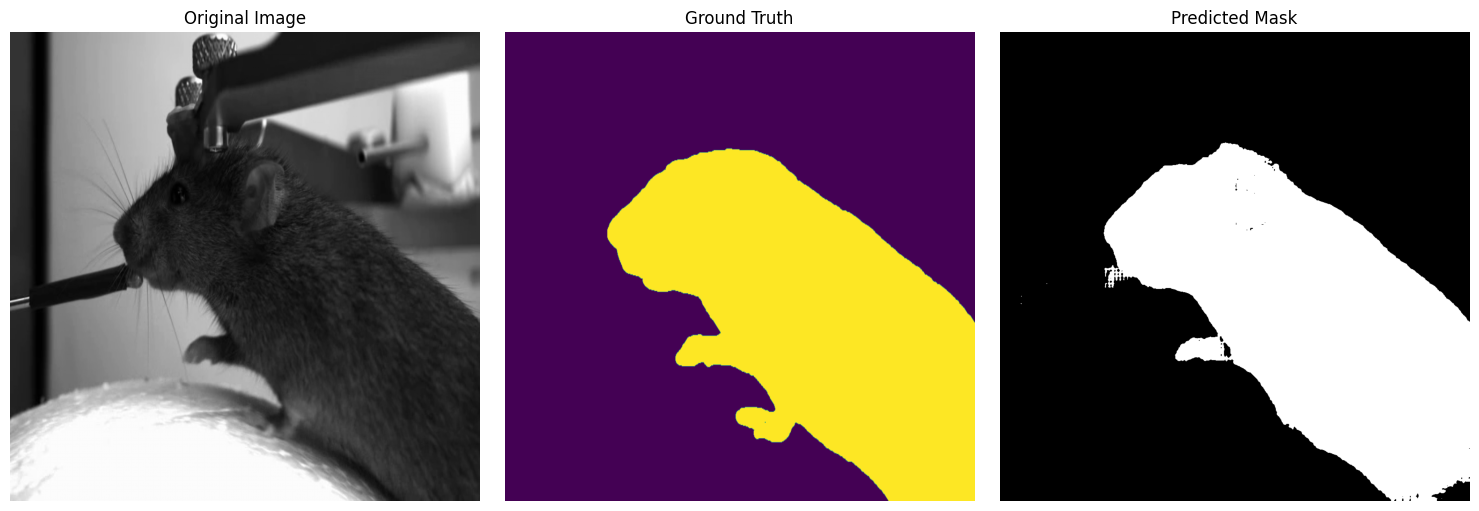

In [46]:
import matplotlib.pyplot as plt

for i in range(10):

    image = TF.resize(data[i], [IM_SIZE, IM_SIZE])
    target = TF.resize(targets[i], [IM_SIZE, IM_SIZE])
    if image.shape[0] == 1:
        image = image.repeat(3, 1, 1)
    image = image.to(DEVICE)
    image_np = image.permute(1, 2, 0).cpu().numpy()  # from CHW to HWC
    targets_np = target.permute(1, 2, 0).cpu().numpy()  # from CHW to HWC


    predictor.set_image(image_np)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False
    )

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    ax[0].imshow(image_np)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    # ground truth 
    ax[1].imshow(targets_np)
    ax[1].set_title("Ground Truth")
    ax[1].axis('off')

    # Predicted mask
    ax[2].imshow(masks[0], cmap='gray')
    ax[2].set_title("Predicted Mask")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()


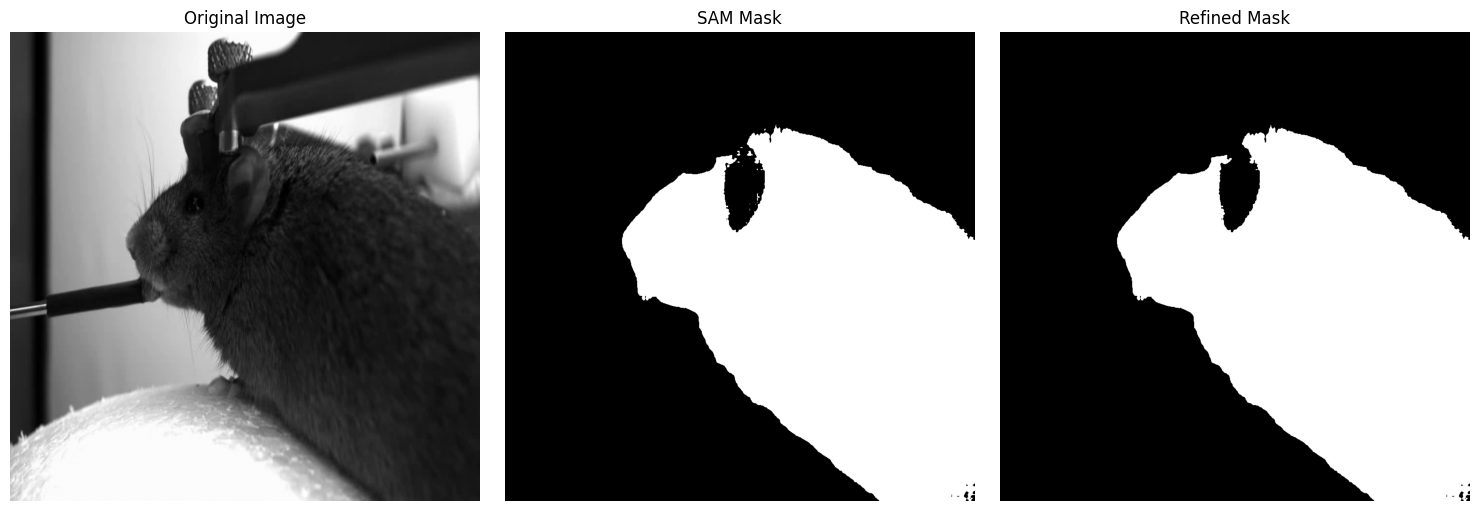

In [28]:
import cv2
import numpy as np

# Convert SAM mask to binary uint8 format
mask_np = (masks[0] > 0).astype(np.uint8) * 255
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_np)
# Ignore background (label 0)
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
refined_mask = (labels == largest_label).astype(np.uint8) * 255

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image_np)
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(mask_np, cmap='gray')
ax[1].set_title("SAM Mask")
ax[1].axis('off')

ax[2].imshow(refined_mask, cmap='gray')
ax[2].set_title("Refined Mask")
ax[2].axis('off')

plt.tight_layout()
plt.show()


In [29]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

class SAMRefinementDataset(Dataset):
    def __init__(self, images, sam_masks, gt_masks, im_size=256):
        self.images = images
        self.sam_masks = sam_masks
        self.gt_masks = gt_masks
        self.im_size = im_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = TF.resize(self.images[idx], [self.im_size, self.im_size])
        sam_mask = TF.resize(self.sam_masks[idx], [self.im_size, self.im_size])
        gt_mask = TF.resize(self.gt_masks[idx], [self.im_size, self.im_size])

        # Normalize image and masks
        image = image.float() / 255.0 if image.max() > 1 else image
        sam_mask = (sam_mask > 0).float()
        gt_mask = (gt_mask > 0).float()

        # Input: [3 + 1, H, W], Target: [1, H, W]
        input_tensor = torch.cat([image, sam_mask], dim=0)
        return input_tensor, gt_mask

import torch.nn as nn

class TinyRefiner(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(4, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 1)
        )

    def forward(self, x):
        return self.net(x)

from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

def train_refiner(model, loader_train, loader_val, epochs=10, lr=1e-3):
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        pbar = tqdm(loader_train, desc=f"[Train] Epoch {epoch}/{epochs}")
        for x, y in pbar:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            loss = F.binary_cross_entropy_with_logits(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(loader_train)
        print(f"Epoch {epoch} Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in loader_val:
                x, y = x.to(DEVICE), y.to(DEVICE)
                pred = model(x)
                loss = F.binary_cross_entropy_with_logits(pred, y)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(loader_val)
        print(f"Epoch {epoch} Val Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), SAVE_DIR / "refiner_best.pth")
            print(f"✅ Saved best model at epoch {epoch}")


def refine_mask(model, image, sam_mask, device="cuda"):
    model.eval()
    with torch.no_grad():
        image = TF.resize(image, [256, 256])
        sam_mask = TF.resize(sam_mask, [256, 256])
        image = image.float() / 255.0 if image.max() > 1 else image
        sam_mask = (sam_mask > 0).float()
        input_tensor = torch.cat([image, sam_mask], dim=0).unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor))[0, 0]
        refined = torch.logical_or(sam_mask > 0.5, pred > 0.5)
        return refined.cpu()



In [33]:
class RefinementDataset(Dataset):
    def __init__(self, data_file=DATA_FILE, sam_model=None, im_size=IM_SIZE):
        super().__init__()
        self.data, self.targets = torch.load(data_file)
        self.sam = sam_model
        self.im_size = im_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].clone()
        gt_mask = self.targets[idx].clone()

        # Convert grayscale to RGB
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        # Resize
        image = TF.resize(image, [self.im_size, self.im_size])
        gt_mask = TF.resize(gt_mask, [self.im_size, self.im_size])

        # Normalize image
        image = image.float() / 255.0 if image.max() > 1 else image

        # Run SAM to get predicted mask
        image_np = image.permute(1, 2, 0).cpu().numpy()
        from segment_anything import SamPredictor
        predictor = SamPredictor(self.sam)
        predictor.set_image(image_np)
        input_point = np.array([[self.im_size // 2, self.im_size // 2]])
        input_label = np.array([1])
        masks, _, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False
        )
        sam_mask = torch.tensor(masks[0]).unsqueeze(0)

        # Input: image + SAM mask → [4, H, W]
        input_tensor = torch.cat([image, sam_mask], dim=0)
        target_tensor = (gt_mask > 0).float()

        return input_tensor, target_tensor


In [34]:
sam_model = load_sam(SAM_MODEL_VERSION, SAM_CHECKPOINT_DIR)
refine_dataset = RefinementDataset(data_file=DATA_FILE, sam_model=sam_model, im_size=IM_SIZE)

N = len(refine_dataset)
train_idx = np.arange(int(0.6 * N))
val_idx = np.arange(int(0.6 * N), int(0.8 * N))
test_idx = np.arange(int(0.8 * N), N)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

loader_train = DataLoader(refine_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, drop_last=True)
loader_val = DataLoader(refine_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, drop_last=False)
loader_test = DataLoader(refine_dataset, batch_size=1, sampler=test_sampler, drop_last=False)



Checkpoint for vit_b already exists at sam_checkpoints\sam_vit_b.pth


In [35]:
model = TinyRefiner()
train_refiner(model, loader_train, loader_val, epochs=10, lr=1e-3)


[Train] Epoch 1/10: 100%|██████████| 7/7 [02:20<00:00, 20.12s/it, loss=0.584]


Epoch 1 Train Loss: 0.6445
Epoch 1 Val Loss: 0.5720
✅ Saved best model at epoch 1


[Train] Epoch 2/10: 100%|██████████| 7/7 [02:26<00:00, 20.98s/it, loss=0.5]  


Epoch 2 Train Loss: 0.5298
Epoch 2 Val Loss: 0.4652
✅ Saved best model at epoch 2


[Train] Epoch 3/10: 100%|██████████| 7/7 [02:26<00:00, 20.97s/it, loss=0.368]


Epoch 3 Train Loss: 0.4230
Epoch 3 Val Loss: 0.3739
✅ Saved best model at epoch 3


[Train] Epoch 4/10: 100%|██████████| 7/7 [02:26<00:00, 20.95s/it, loss=0.376]


Epoch 4 Train Loss: 0.3512
Epoch 4 Val Loss: 0.3103
✅ Saved best model at epoch 4


[Train] Epoch 5/10: 100%|██████████| 7/7 [02:27<00:00, 21.03s/it, loss=0.244]


Epoch 5 Train Loss: 0.2951
Epoch 5 Val Loss: 0.2976
✅ Saved best model at epoch 5


[Train] Epoch 6/10: 100%|██████████| 7/7 [02:26<00:00, 20.98s/it, loss=0.183]


Epoch 6 Train Loss: 0.2662
Epoch 6 Val Loss: 0.2478
✅ Saved best model at epoch 6


[Train] Epoch 7/10: 100%|██████████| 7/7 [02:27<00:00, 21.01s/it, loss=0.227]


Epoch 7 Train Loss: 0.2399
Epoch 7 Val Loss: 0.2267
✅ Saved best model at epoch 7


[Train] Epoch 8/10: 100%|██████████| 7/7 [02:26<00:00, 20.96s/it, loss=0.138]


Epoch 8 Train Loss: 0.2195
Epoch 8 Val Loss: 0.2127
✅ Saved best model at epoch 8


[Train] Epoch 9/10: 100%|██████████| 7/7 [02:26<00:00, 20.99s/it, loss=0.217]


Epoch 9 Train Loss: 0.2224
Epoch 9 Val Loss: 0.2088
✅ Saved best model at epoch 9


[Train] Epoch 10/10: 100%|██████████| 7/7 [02:26<00:00, 20.93s/it, loss=0.12] 


Epoch 10 Train Loss: 0.2053
Epoch 10 Val Loss: 0.2390


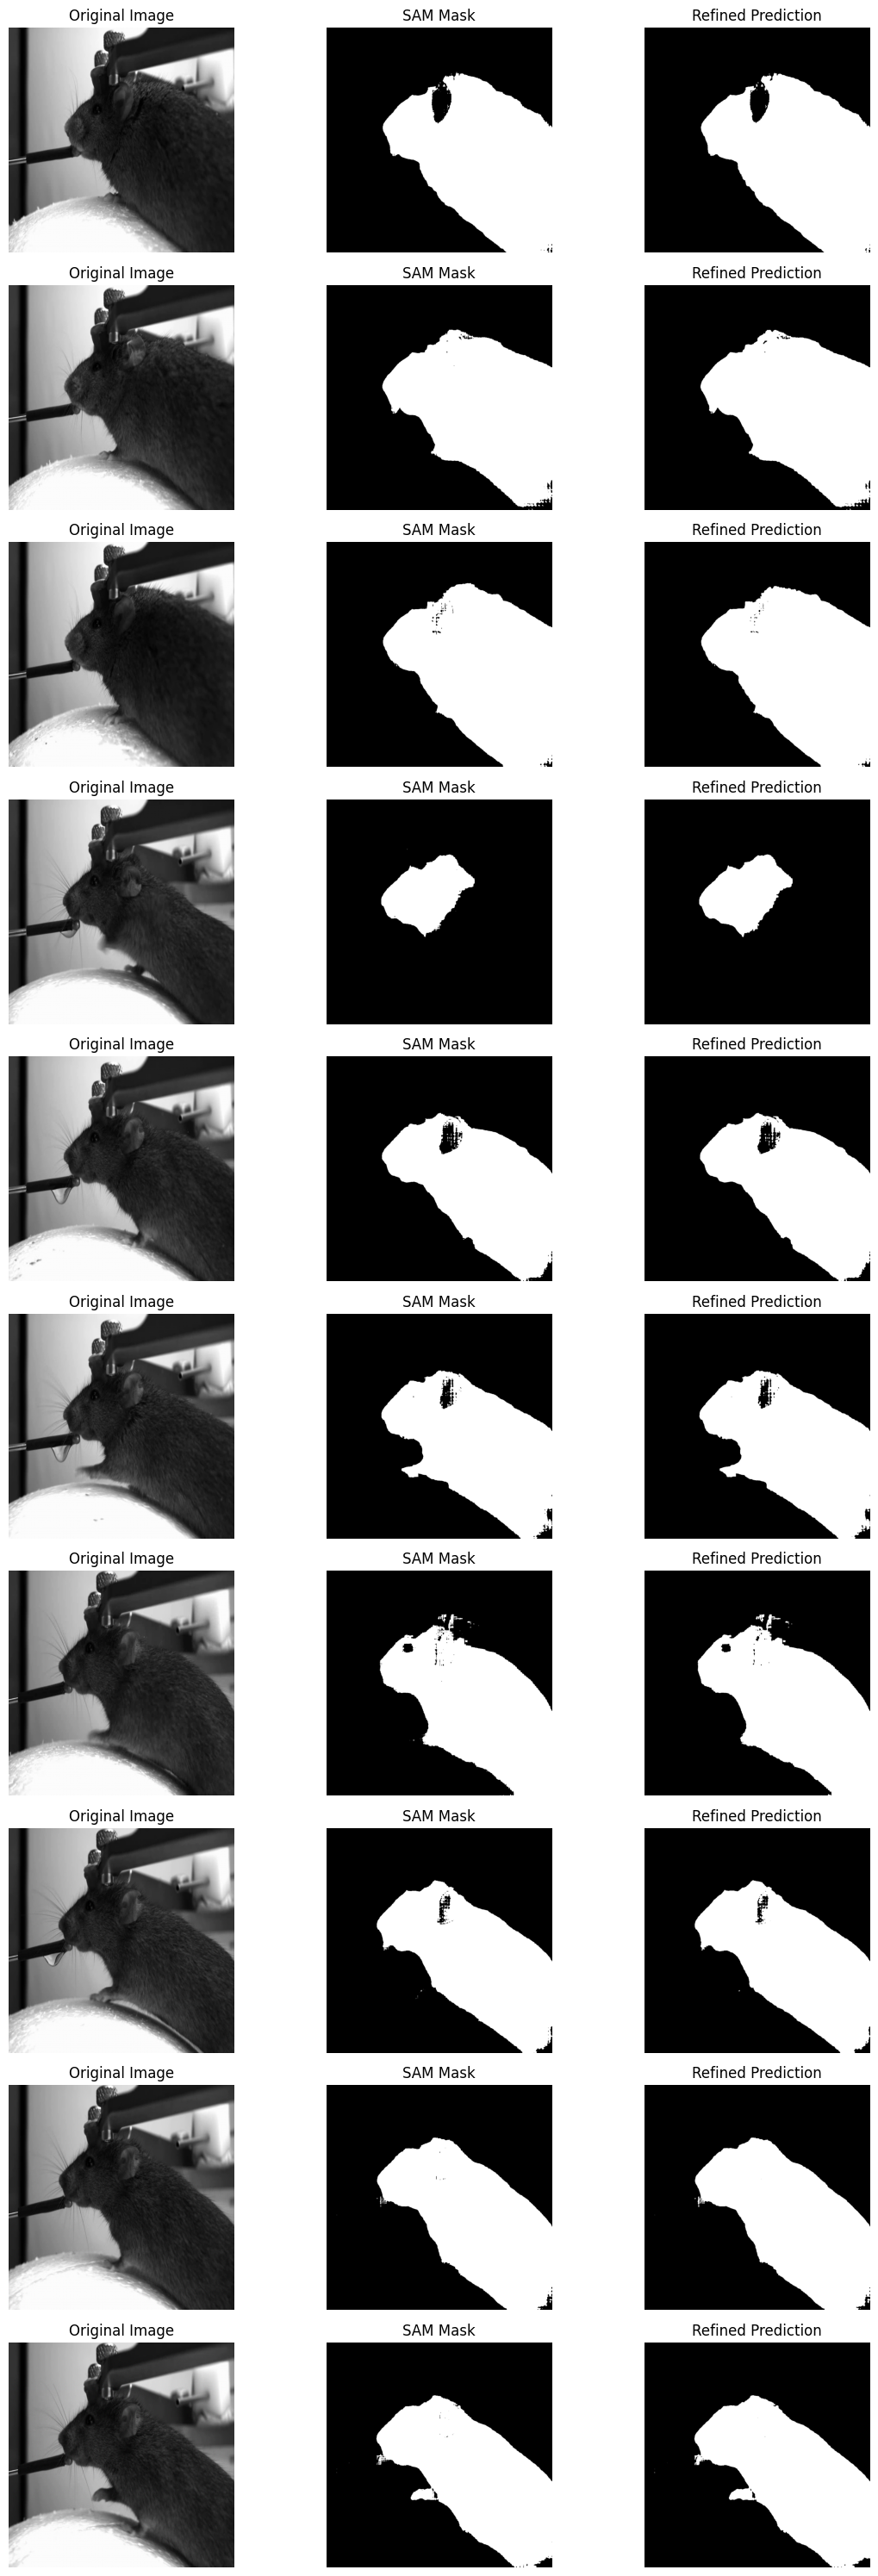

In [37]:
import matplotlib.pyplot as plt

def plot_refiner_predictions(model, dataset, count=10):
    model.eval()
    fig, axes = plt.subplots(count, 3, figsize=(12, 3 * count))

    for i in range(count):
        input_tensor, target = dataset[i]
        image = input_tensor[:3]  # RGB
        sam_mask = input_tensor[3:]  # SAM mask
        with torch.no_grad():
            pred = torch.sigmoid(model(input_tensor.unsqueeze(0).to(DEVICE)))[0, 0].cpu()

        axes[i, 0].imshow(image.permute(1, 2, 0))
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(sam_mask[0], cmap='gray')
        axes[i, 1].set_title("SAM Mask")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred > 0.5, cmap='gray')
        axes[i, 2].set_title("Refined Prediction")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

plot_refiner_predictions(model, refine_dataset, count=10)
